__Обучите нейронную сеть U-Net на любом датасете. Проведите эксперименты с размером сети , числом ядер, добавьте аугментацию. Соберите результаты в таблицу и сделайте вывод, что влияет на качество сегментации. Что помогло вам улучшить ее точность?__

In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from google.colab import files
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
import numpy as np
from PIL import Image
from tensorflow.keras.utils import plot_model
from google.colab import files

In [2]:
uploaded = files.upload()

Saving small_segment.rar to small_segment (2).rar


In [3]:
!pip install rarfile

In [4]:
import rarfile

rf = rarfile.RarFile("small_segment.rar")
for f in rf.infolist():
    # print(f.filename, f.file_size)
    if f.filename == "README":
        print(rf.read(f))
rf.extractall()

In [5]:
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

In [6]:
def cuttedUnet(num_classes=14, input_shape=(200, 600, 3), kernel_conv_size=3, multiplier_kernel=1, add_blocks=False, summary_info=True):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(int(64*multiplier_kernel), (kernel_conv_size, kernel_conv_size), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(int(64*multiplier_kernel), (kernel_conv_size, kernel_conv_size), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out)

    # Block 2
    x = Conv2D(int(128*multiplier_kernel), (kernel_conv_size, kernel_conv_size), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(int(128*multiplier_kernel), (kernel_conv_size, kernel_conv_size), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out)

    # Block 3
    x = Conv2D(int(256*multiplier_kernel), (kernel_conv_size, kernel_conv_size), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(int(256*multiplier_kernel), (kernel_conv_size, kernel_conv_size), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(int(256*multiplier_kernel), (kernel_conv_size, kernel_conv_size), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out)

    # Block 4
    x = Conv2D(int(512*multiplier_kernel), (kernel_conv_size, kernel_conv_size), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(int(512*multiplier_kernel), (kernel_conv_size, kernel_conv_size), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(int(512*multiplier_kernel), (kernel_conv_size, kernel_conv_size), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_4_out = Activation('relu')(x)

    if add_blocks:
        x = MaxPooling2D()(block_4_out)

        # Block 5
        x = Conv2D(int(512*multiplier_kernel), (kernel_conv_size, kernel_conv_size), padding='same', name='block5_conv1')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(int(512*multiplier_kernel), (kernel_conv_size, kernel_conv_size), padding='same', name='block5_conv2')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(int(512*multiplier_kernel), (kernel_conv_size, kernel_conv_size), padding='same', name='block5_conv3')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)


        # Load pretrained weights.
        #for_pretrained_weight = MaxPooling2D()(x)
        #vgg16 = Model(img_input, for_pretrained_weight)
        #vgg16.load_weights('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', by_name=True)

        x = Conv2DTranspose(int(512*multiplier_kernel), (2, 2), strides=(2, 2), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = concatenate([x, block_4_out])
        x = Conv2D(int(512*multiplier_kernel), (kernel_conv_size, kernel_conv_size), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(int(512*multiplier_kernel), (kernel_conv_size, kernel_conv_size), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(int(256*multiplier_kernel), (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_3_out])
    x = Conv2D(int(256*multiplier_kernel), (kernel_conv_size, kernel_conv_size), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(int(256*multiplier_kernel), (kernel_conv_size, kernel_conv_size), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(int(128*multiplier_kernel), (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_2_out])
    x = Conv2D(int(128*multiplier_kernel), (kernel_conv_size, kernel_conv_size), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(int(128*multiplier_kernel), (kernel_conv_size, kernel_conv_size), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(int(64*multiplier_kernel), (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_1_out])
    x = Conv2D(int(64*multiplier_kernel), (kernel_conv_size, kernel_conv_size), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(int(64*multiplier_kernel), (kernel_conv_size, kernel_conv_size), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # слой классификатор
    x = Conv2D(num_classes, (kernel_conv_size, kernel_conv_size), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    model.summary() if summary_info else 0
    return model

In [7]:
import os, fnmatch
imag = os.listdir('/content/images')
imag_label = os.listdir('/content/labels')

PAHT_label = '/content/labels/'
PAHT_image = '/content/images/'

In [8]:
N_EPOCHS = 10
N_BATCH_SIZE = 3
N_WORKERS = 8
SIZE_INPUT = (192, 576, 3)

In [9]:
images = []
segments = []
image_size = SIZE_INPUT[:2]
for i_name in imag:
    images.append(image.load_img(PAHT_image+i_name ,target_size=image_size))
    segments.append(image.load_img(PAHT_label+i_name, target_size=image_size))

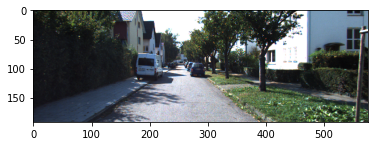

In [10]:
plt.imshow(images[5].convert('RGBA'))
plt.show()

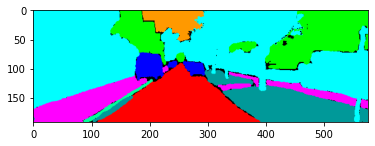

In [11]:
plt.imshow(segments[5].convert('RGBA'))
plt.show()

In [12]:
xTrain_Test = []

for img in images:
    x = image.img_to_array(img)
    xTrain_Test.append(x)

xTrain_Test = np.array(xTrain_Test)
print(xTrain_Test.shape)

(17, 192, 576, 3)


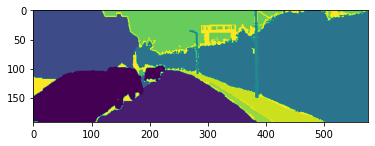

In [13]:
def Color2index(y):
    arr_col=[[0,0,255],[255,0,0],[255,255,0],[0,255,0],[255,0,255],[0,255,255],[255,0,153],[153,0,255],[0,153,255],[153,255,0],[255,153,0],[0,255,153],[0,153,153],[0,0,0]]
    y_ind = np.zeros((y.shape[0],y.shape[1]))
    y_cat = np.zeros((y.shape[0],y.shape[1], len(arr_col)))
    i = 1
    for i_color in arr_col:
        ind_i = np.where((y[:,:,0]==i_color[0])&(y[:,:,1]==i_color[1])&(y[:,:,2]==i_color[2]))
        y_ind[ind_i[0],ind_i[1]] = i
        y_cat[ind_i[0],ind_i[1], i-1] = 1 
        i += 1
  
    return y_cat, y_ind, i-1
cat_yi,ind_yi,h = Color2index(image.img_to_array(segments[0]))
plt.imshow(ind_yi.astype(float)/h)
plt.show() 

In [14]:
yTrain_Test = []

for seg in segments:
    y_cat,_,_ = Color2index(image.img_to_array(seg))
    yTrain_Test.append(y_cat)

yTrain_Test = np.array(yTrain_Test)
print(yTrain_Test.shape)

(17, 192, 576, 14)


In [15]:
N = 15
yTrain = yTrain_Test[:N,:,:,:]
xTrain = xTrain_Test[:N,:,:,:]

yTest = yTrain_Test[N:,:,:,:]
xTest = xTrain_Test[N:,:,:,:]

In [16]:
def get_history_plot(history, title=""):
    plt.figure(figsize=(10, 7))
    plt.plot(history.history['val_dice_coef'],label = 'test')
    plt.plot(history.history['dice_coef'],label='train')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('dice_coef')
    plt.title(title)
    plt.show()

In [17]:
datagen = image.ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    shear_range=0.,
    zoom_range=0.0,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.0)

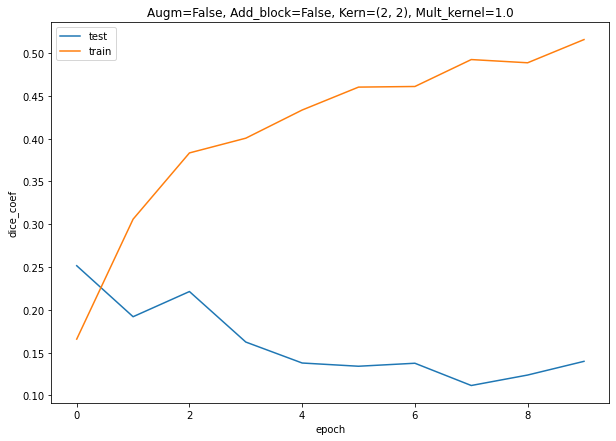

Instructions for updating:
Please use Model.fit, which supports generators.


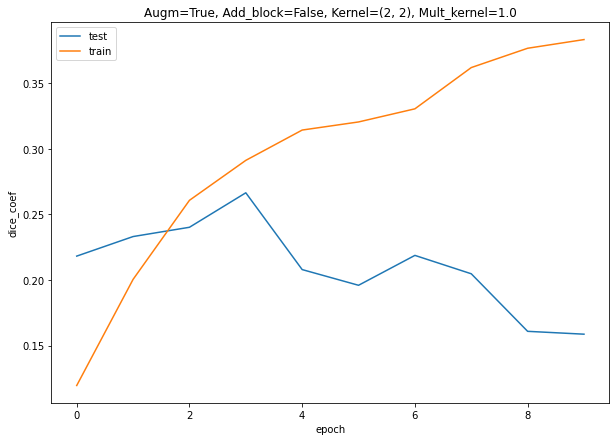

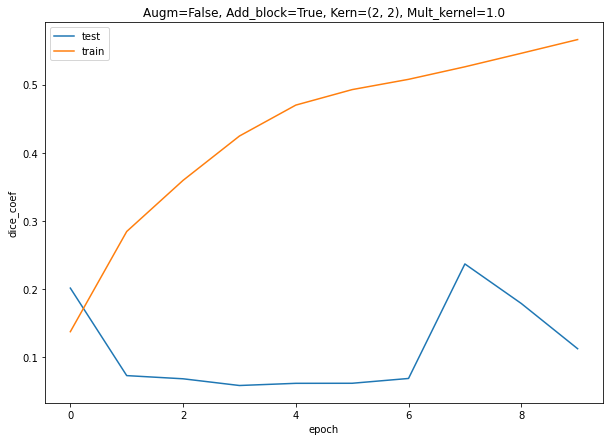

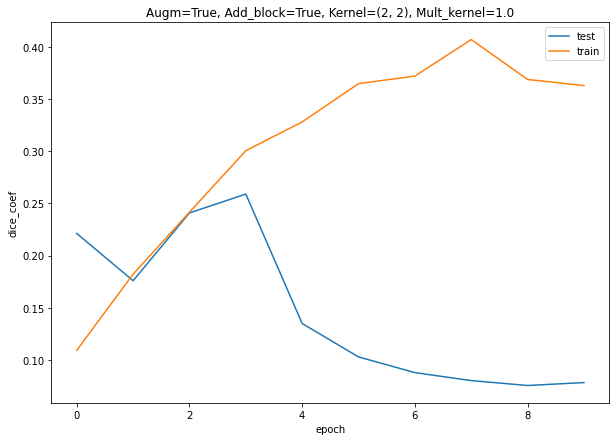

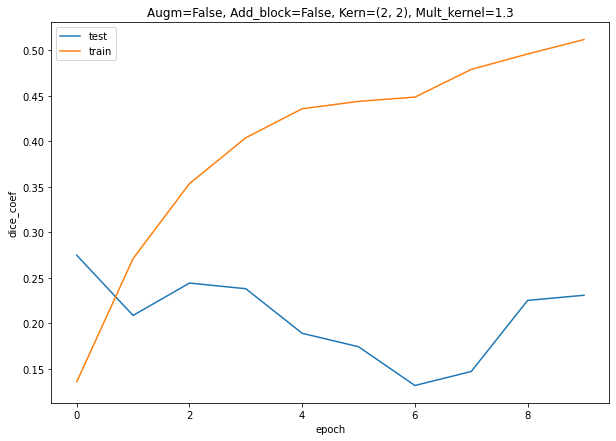

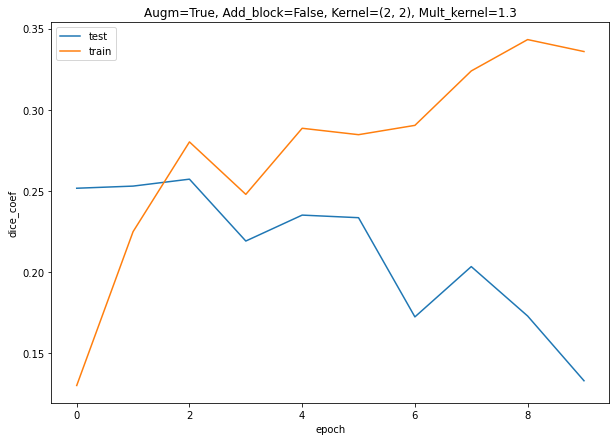

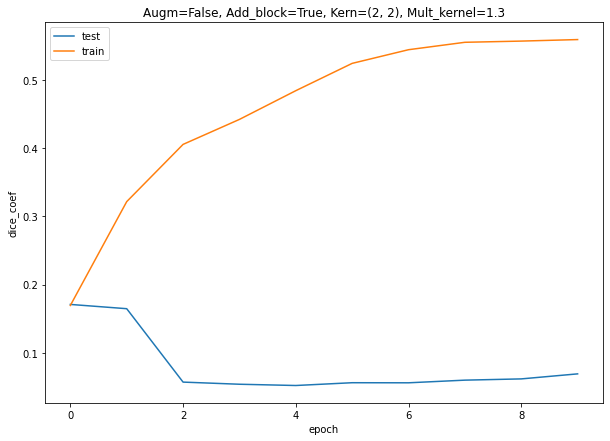

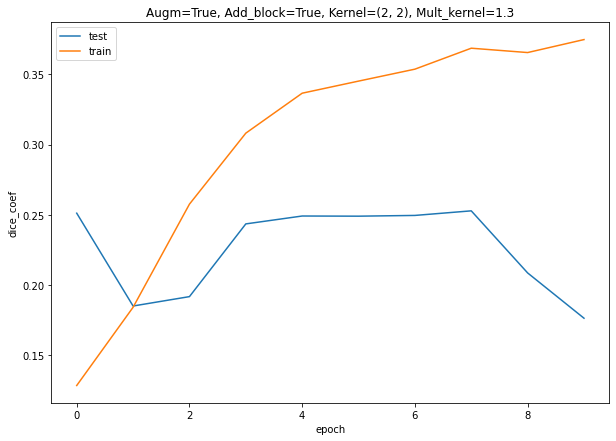

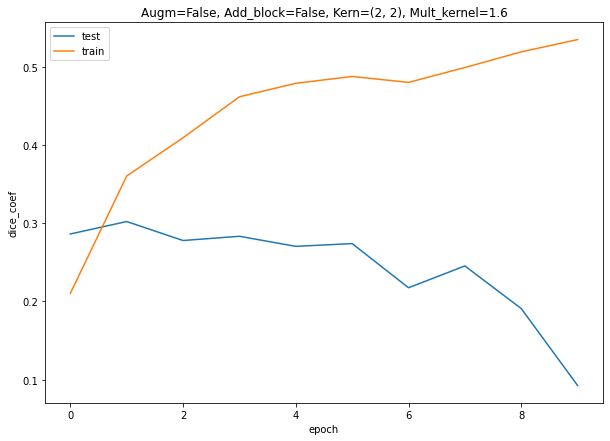

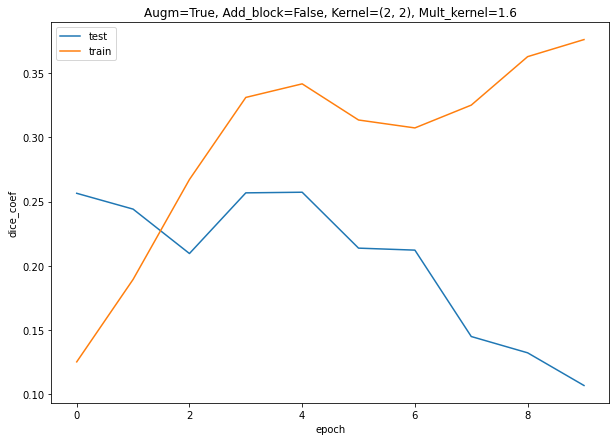

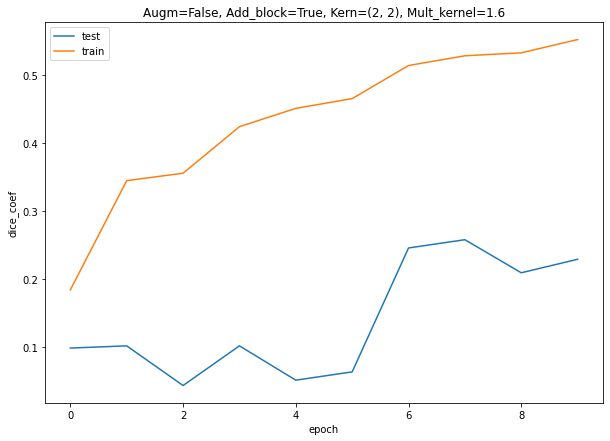

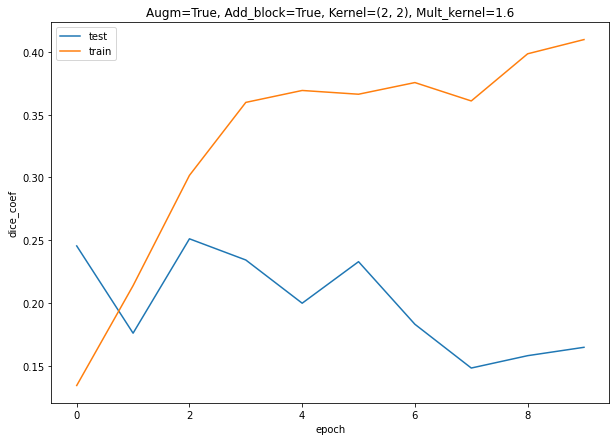

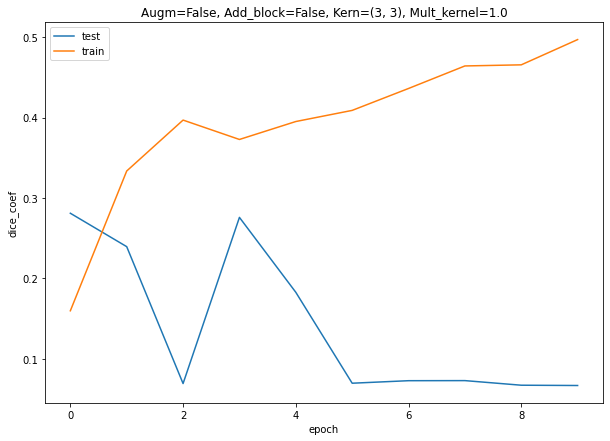

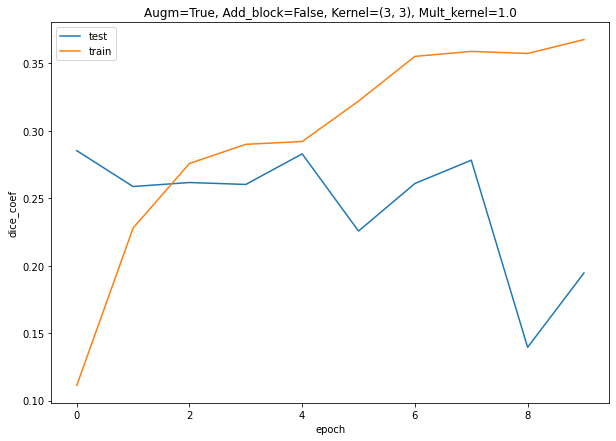

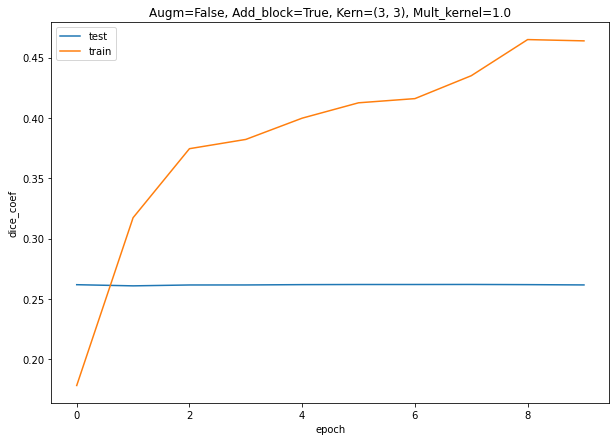

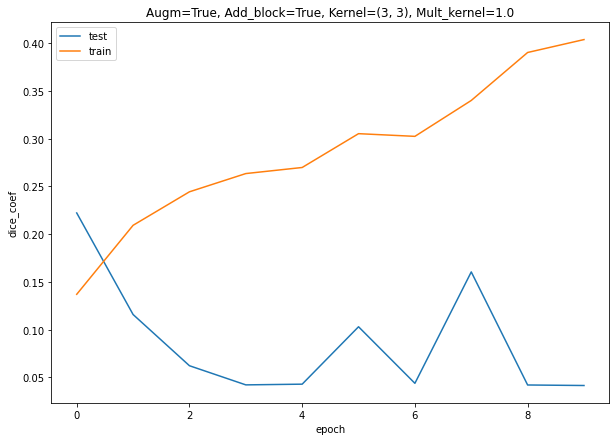

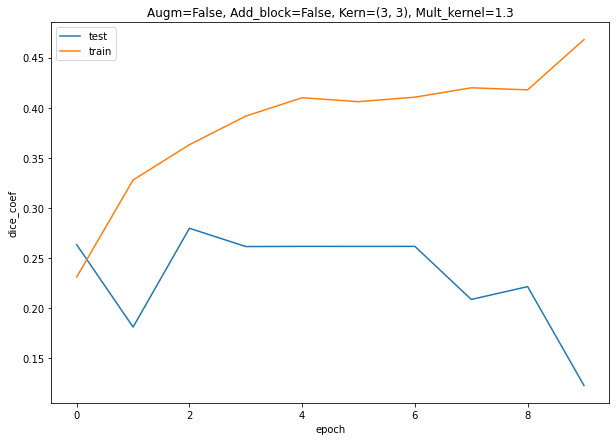

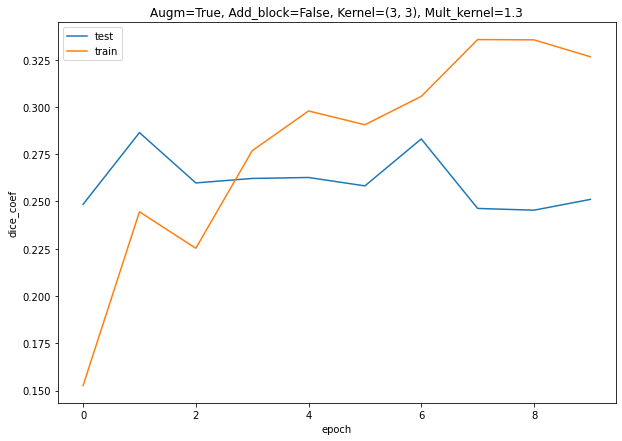

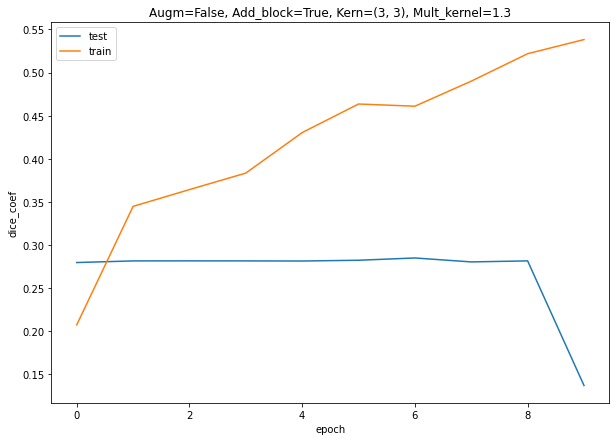

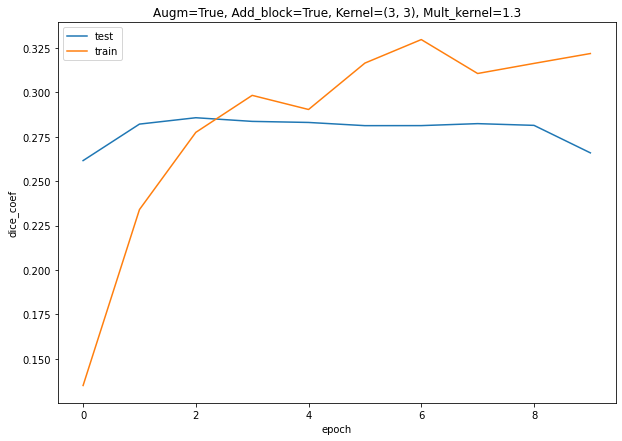

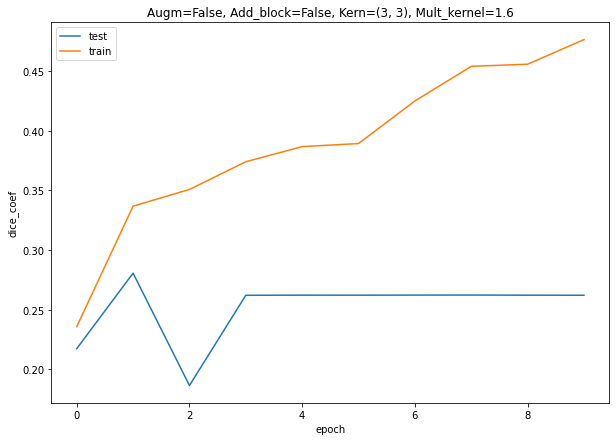

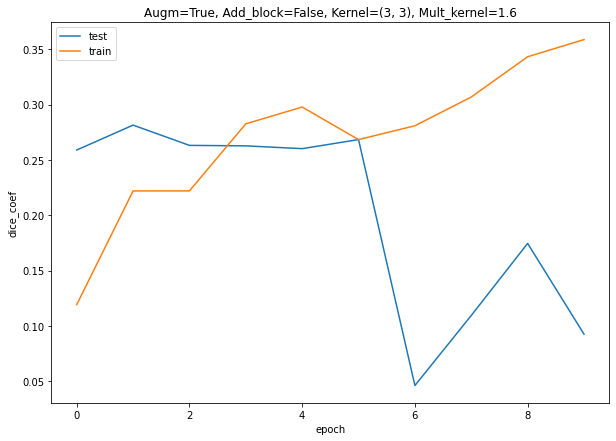

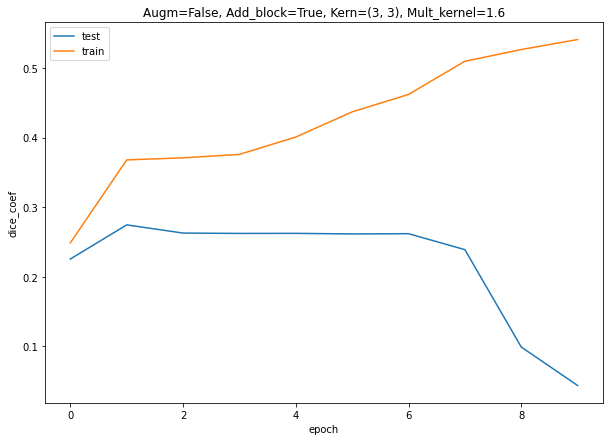

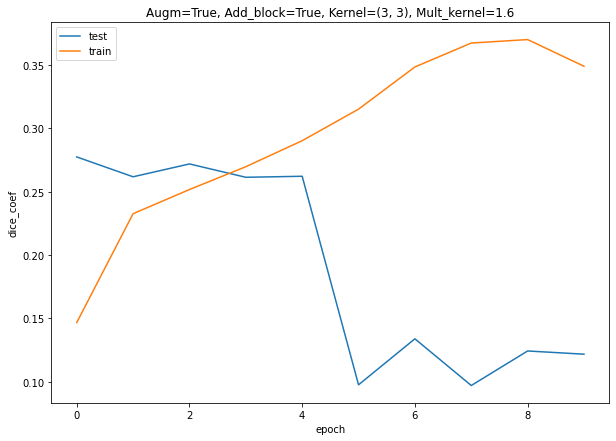

In [18]:
data_plate = {}
VERBOSE_LVL = 0

for kernel in range(2, 4):
    for multiplier in np.arange(1, 1.7, 0.3):
        for add_block in [False, True]:

            modelC = cuttedUnet(14, SIZE_INPUT, kernel_conv_size=kernel, add_blocks=add_block, multiplier_kernel=multiplier, summary_info=False)
            history = modelC.fit(xTrain, yTrain, epochs=N_EPOCHS, batch_size=N_BATCH_SIZE, validation_data=(xTrain, yTrain), verbose=VERBOSE_LVL)
            title = f"Augm=False, Add_block={add_block}, Kern={(kernel, kernel)}, Mult_kernel={multiplier}"
            get_history_plot(history, title=title)
            data_plate[title] = history.history['val_dice_coef']

            modelC = cuttedUnet(14, SIZE_INPUT, kernel_conv_size=kernel, add_blocks=add_block, summary_info=False)
            history = modelC.fit_generator(datagen.flow(xTrain, yTrain, batch_size=N_BATCH_SIZE), 
                                           epochs=N_EPOCHS, 
                                           validation_data=(xTrain, yTrain), 
                                           workers=N_WORKERS, 
                                           verbose=VERBOSE_LVL)
            title = f"Augm=True, Add_block={add_block}, Kernel={(kernel, kernel)}, Mult_kernel={multiplier}"
            get_history_plot(history, title=title)
            data_plate[title] = history.history['val_dice_coef']

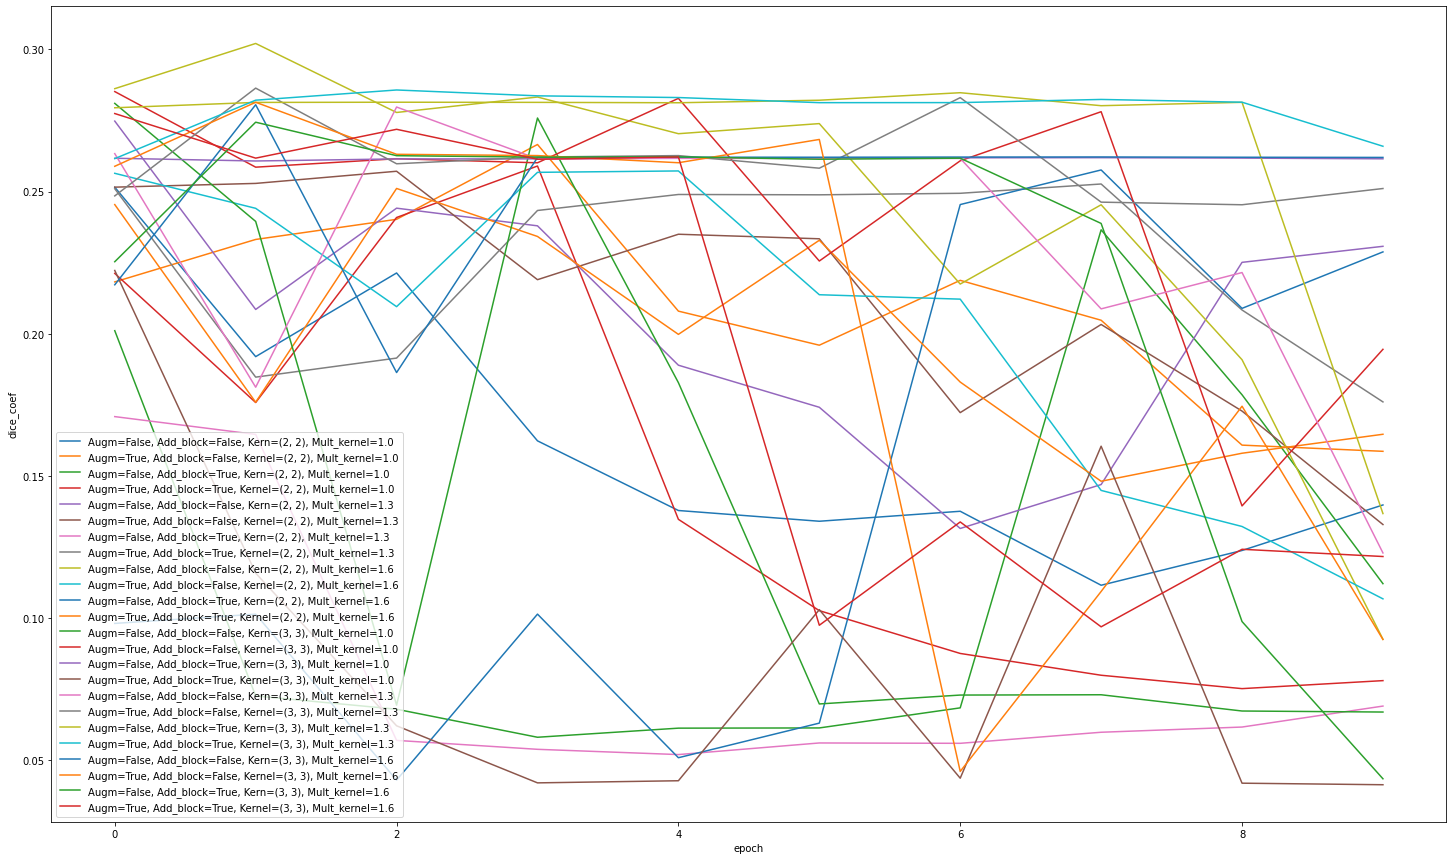

In [19]:
plt.figure(figsize=(25, 15))

for key in data_plate.keys():
    plt.plot(data_plate[key], label=key)

plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.legend()
plt.show()

__Правильное сочетание глубины сети и размера ядер позволяет улучшить качество сегментации, аугментация помогает улучшить качество при правильных параметрах и ухудшить - при неправильных. Высокое качество показывают как сети, обученные на аугментированных данных, так и обученные только на оригинальных, что, скорее всего, вызвано малым количеством обучающих данных.__